<a href="https://colab.research.google.com/github/mashyko/Image-Classifier/blob/master/Pytorch_AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# パッケージのimportとPyTorchのバージョンを確認

In [ ]:
# パッケージのimport
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
from torchvision import models, transforms


In [ ]:
# PyTorchのバージョン確認
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)


PyTorch Version:  1.7.0+cu101
Torchvision Version:  0.8.1+cu101


In [ ]:
# 学習済みのAlexNetモデルをロード

net = models.alexnet(pretrained=True)# 学習済みのパラメータを使用
net.eval()  # 推論モードに設定

print(net)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# 入力画像の前処理クラスを作成

In [ ]:
# 入力画像の前処理のクラス
class BaseTransform():
    """
    画像のサイズをリサイズし、色を標準化する。
    resize : int リサイズ先の画像の大きさ。
    mean : (R, G, B) 各色チャネルの平均値。
    std : (R, G, B) 各色チャネルの標準偏差。
    """

    def __init__(self, resize, mean, std):
        self.base_transform = transforms.Compose([
            transforms.Resize(resize),  # 短い辺の長さがresizeの大きさになる
            transforms.CenterCrop(resize),  # 画像中央をresize × resizeで切り取り
            transforms.ToTensor(),  # Torchテンソルに変換
            transforms.Normalize(mean, std)  # 色情報の標準化
        ])

    def __call__(self, img):
        return self.base_transform(img)


#画像データを読み込みます。
私の GitHub Repo に必要な画像がありますので、ダウンロードします。

fatal: destination path 'Image-Classifier' already exists and is not an empty directory.
/content/Image-Classifier
289376763_4f2dee00c9.jpg  fotos_labrador.jpg	lemon.jpg
cat.jpg			  Goldenellie.jpg	orange.jpg
elephant.jpg		  golden_retriever.jpg	orangutan.jpg
flower.jpg		  labrador4_l.jpg


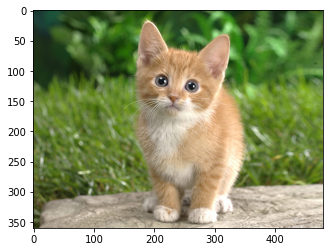

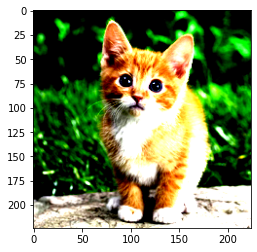

In [ ]:
!git clone https://github.com/mashyko/Image-Classifier
%cd Image-Classifier
!ls images/

# 1. 画像読み込み

image_file_path = './images/cat.jpg'
img = Image.open(image_file_path)  # [高さ][幅][色RGB]

# 2. 元の画像の表示
plt.imshow(img)
plt.show()

# 3. 画像の前処理と処理済み画像の表示
resize = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
transform = BaseTransform(resize, mean, std)
img_transformed = transform(img)  # torch.Size([3, 224, 224])

# (色、高さ、幅)を (高さ、幅、色)に変換し、0-1に値を制限して表示
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()


# 出力結果からラベルを予測する後処理クラスを作成

In [ ]:
# ILSVRCのラベル情報をロードし辞意書型変数を生成します
class_index = json.load(open('./data/imagenet_class_index.json', 'r'))
#class_index


In [ ]:
# 出力結果からラベルを予測する後処理クラス
class Predictor():

    def __init__(self, class_index):
        self.class_index = class_index

    def predict_max(self, out):
        """
        確率最大のラベル名を取得する。
        out : torch.Size([1, 1000]) Netからの出力。
        """
        maxid = np.argmax(out.detach().numpy())
        predicted_label_name = self.class_index[str(maxid)][1]

        return predicted_label_name


# 学習済みAlexNetモデルで手元の画像を予測

In [ ]:
# Predictorのインスタンスを生成します
predictor = Predictor(class_index)

# 前処理の後、バッチサイズの次元を追加する
transform = BaseTransform(resize, mean, std)  # 前処理クラス作成
img_transformed = transform(img)  # torch.Size([3, 224, 224])
inputs = img_transformed.unsqueeze_(0)  # torch.Size([1, 3, 224, 224])

# モデルに入力し、モデル出力をラベルに変換する
out = net(inputs)  # torch.Size([1, 1000])
result = predictor.predict_max(out)

# 予測結果を出力する
print("入力画像の予測結果：", result)



入力画像の予測結果： Egyptian_cat


以上